<a href="https://colab.research.google.com/github/ljrn8/quick-notebooks/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP3010 Machine Learning Assignment | 20757218 Joel Hoefs


## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn

!pip install -U numpy
!pip install -U optuna
!curl -LJO https://raw.githubusercontent.com/qilinli/COMP3010-Machine-Learning/refs/heads/master/2025-assignment/train.csv
!curl -LJO https://raw.githubusercontent.com/qilinli/COMP3010-Machine-Learning/refs/heads/master/2025-assignment/test.csv

files = os.listdir('.')
assert 'test.csv' in files
assert 'train.csv' in files
print(files)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 978.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 29.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.1 MB/s eta 0:00:00
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1186k  10

In [2]:
df = pd.read_csv('train.csv', index_col=False)      # train/validation
test_df = pd.read_csv('test.csv', index_col=False)  # test
len(df), len(test_df)

(10050, 3203)

In [3]:
df.columns

Index(['Unnamed: 0', 'Tank Failure Pressure (bar)', 'Liquid Ratio',
       'Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)',
       'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)',
       'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)',
       'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)',
       'Obstacle Angle', 'Status', 'Liquid Critical Pressure (bar)',
       'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)',
       'Sensor ID', 'Sensor Position Side', 'Sensor Position x',
       'Sensor Position y', 'Sensor Position z', 'Target Pressure (bar)'],
      dtype='object')

In [4]:
for data in (df, test_df):
  data = data.drop('Unnamed: 0', axis=1)

## Preprocessing


In [5]:
print(f'na rows in train/valid: {len(df.dropna()) - len(df)}')
print(f'na rows in test: {len(test_df.dropna()) - len(test_df)}')

na rows in train/valid: -110
na rows in test: 0


In [6]:
# 110 is insignificant -> delete columns
df = df.dropna()

In [7]:
from scipy import stats

# filter outliers with the Z score method
def filter_outliers(df, cols, threshhold_z=2):
  df_c = df[cols]
  z = stats.zscore(df_c)
  non_outliers = abs(z) < threshhold_z

  print()
  for c in cols:
    print(f'outliers in [{c}] = {(~non_outliers[c]).sum()}')

  non_outliers_mask = non_outliers.all(axis=1)
  outliers = len(df_c) - len(df_c[non_outliers_mask])
  rate = outliers / len(df_c)
  print(f'num outliers: {outliers}\noutlier rate: {rate*100} %')

  return non_outliers_mask, df[non_outliers_mask]

drop_cols = ['Status', 'Unnamed: 0']
non_outliers_mask, filtered = filter_outliers(df, df.drop(drop_cols, axis=1).columns, threshhold_z=3.5)
non_outliers_mask_test, filtered_test = filter_outliers(test_df, test_df.drop(drop_cols, axis=1).columns, threshhold_z=3.5)


outliers in [Tank Failure Pressure (bar)] = 48
outliers in [Liquid Ratio] = 0
outliers in [Tank Width (m)] = 0
outliers in [Tank Length (m)] = 0
outliers in [Tank Height (m)] = 0
outliers in [BLEVE Height (m)] = 0
outliers in [Vapour Height (m)] = 0
outliers in [Vapour Temperature (K)] = 0
outliers in [Liquid Temperature (K)] = 0
outliers in [Obstacle Distance to BLEVE (m)] = 0
outliers in [Obstacle Width (m)] = 0
outliers in [Obstacle Height (m)] = 0
outliers in [Obstacle Thickness (m)] = 0
outliers in [Obstacle Angle] = 0
outliers in [Liquid Critical Pressure (bar)] = 0
outliers in [Liquid Boiling Temperature (K)] = 0
outliers in [Liquid Critical Temperature (K)] = 0
outliers in [Sensor ID] = 0
outliers in [Sensor Position Side] = 0
outliers in [Sensor Position x] = 0
outliers in [Sensor Position y] = 10
outliers in [Sensor Position z] = 0
outliers in [Target Pressure (bar)] = 142
num outliers: 200
outlier rate: 2.0120724346076457 %

outliers in [Tank Failure Pressure (bar)] = 0
out

In [8]:
df = df[non_outliers_mask]

In [9]:
# drop duplicates
print(len(df))
df = df.drop_duplicates()
print(len(df))

9740
9692


In [10]:
# remove unvalid entries
def filter_range(df, c, ub, lb):
  df_filtered = df[(df[c] >= lb) & (df[c] <= ub)]
  n_filtered =  len(df) - len(df_filtered)
  print(f'number of out-of-bounds [{c}] instances = {n_filtered}')
  return df_filtered

# rational metric upperbound for Kelvin/metres
UB = 1_000

filter_range_map = {
  'Tank Failure Pressure (bar)': (0, np.inf),
  'Liquid Ratio': (0, 1),
  'Tank Width (m)': (0, UB),
  'Tank Length (m)': (0, UB),
  'Tank Height (m)': (0, UB),
  'Vapour Height (m)': (0, UB),
  'BLEVE Height (m)': (0, UB),
  'Vapour Temperature (K)': (0, np.inf),
  'Liquid Temperature (K)': (0, UB),
  'Obstacle Distance to BLEVE (m)': (0, UB),
  'Obstacle Width (m)': (0, UB),
  'Obstacle Height (m)': (0, UB),
  'Obstacle Thickness (m)': (0, UB),
  'Obstacle Angle': (0, 30),
  'Sensor ID': (1, 27),
  'Sensor Position Side': (1, 5),
  'Sensor Position x': (-UB, UB),
  'Sensor Position y': (-UB, UB),
  'Sensor Position z': (-UB, UB),
  'Target Pressure (bar)': (0, np.inf),
}

df_interm = df.copy()
for column, (lb, ub) in filter_range_map.items():
  train_interm = filter_range(df_interm, column, ub, lb)

number of out-of-bounds [Tank Failure Pressure (bar)] instances = 0
number of out-of-bounds [Liquid Ratio] instances = 0
number of out-of-bounds [Tank Width (m)] instances = 0
number of out-of-bounds [Tank Length (m)] instances = 0
number of out-of-bounds [Tank Height (m)] instances = 0
number of out-of-bounds [Vapour Height (m)] instances = 0
number of out-of-bounds [BLEVE Height (m)] instances = 149
number of out-of-bounds [Vapour Temperature (K)] instances = 0
number of out-of-bounds [Liquid Temperature (K)] instances = 0
number of out-of-bounds [Obstacle Distance to BLEVE (m)] instances = 0
number of out-of-bounds [Obstacle Width (m)] instances = 0
number of out-of-bounds [Obstacle Height (m)] instances = 0
number of out-of-bounds [Obstacle Thickness (m)] instances = 0
number of out-of-bounds [Obstacle Angle] instances = 0
number of out-of-bounds [Sensor ID] instances = 0
number of out-of-bounds [Sensor Position Side] instances = 0
number of out-of-bounds [Sensor Position x] instan

(-0.05, 0.3)

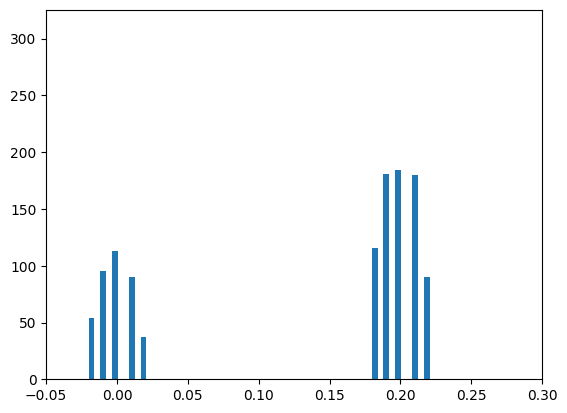

In [11]:
plt.hist(df['BLEVE Height (m)'], bins=500)
plt.xlim(-0.05, 0.3)

In [12]:
# some BLEVE Height (m) measurements were negative, so I'll just round them up
df['BLEVE Height (m)'] = df['BLEVE Height (m)'].map(lambda x: max(x, 0))

In [13]:
# ensure no incorrect categorical/ordinal entries:
for c in ('Status', 'Sensor Position Side', 'Sensor ID'):
  print(c + ' unique values: ')
  print(np.unique(df[c]))
  print()

Status unique values: 
['Saperheated' 'Subcoled' 'Subcool' 'Subcooled' 'Superheat' 'Superheated'
 'subcooled' 'superheated']

Sensor Position Side unique values: 
[1. 2. 3. 4. 5.]

Sensor ID unique values: 
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27.]



In [14]:
def status_map(name):
  if name in ['Saperheated', 'Superheat', 'Superheated', 'superheated']:
    return 'superheated'
  else:
    return 'subcooled'

df['Status'] = df['Status'].map(status_map)
np.unique(df['Status'])

array(['subcooled', 'superheated'], dtype=object)

In [15]:
# Feature Engineering:
for data in (df, test_df):

  # Dimension Ratio's
  data['Tank width/length Ratio'] = data['Tank Width (m)'] / data['Tank Length (m)']
  data['Tank width/height Ratio'] =  data['Tank Width (m)'] / data['Tank Height (m)']

  # precise distance to sensor
  sensor_offsets = np.sqrt(data['Sensor Position x']**2 + data['Sensor Position y']**2 + data['Sensor Position z']**2)
  data['Sensor-Obstacle Distance'] = data['Obstacle Distance to BLEVE (m)'] + sensor_offsets

In [16]:
# data type conversion
df['Status'] = df['Status'].map({"superheated": 0, "subcooled": 1})
test_df['Status'] = test_df['Status'].map({"Superheated": 0, "Subcooled": 1})

Feature Selection done with permutation importance using XGBoost

In [17]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.inspection import permutation_importance

X, y = df.drop('Target Pressure (bar)', axis=1), df['Target Pressure (bar)']
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2)

model = xgb.XGBRegressor().fit(X_train, y_train)
model.score(X_val, y_val)

r = permutation_importance(model, X_val, y_val,
                           n_repeats=50,
                           random_state=0)

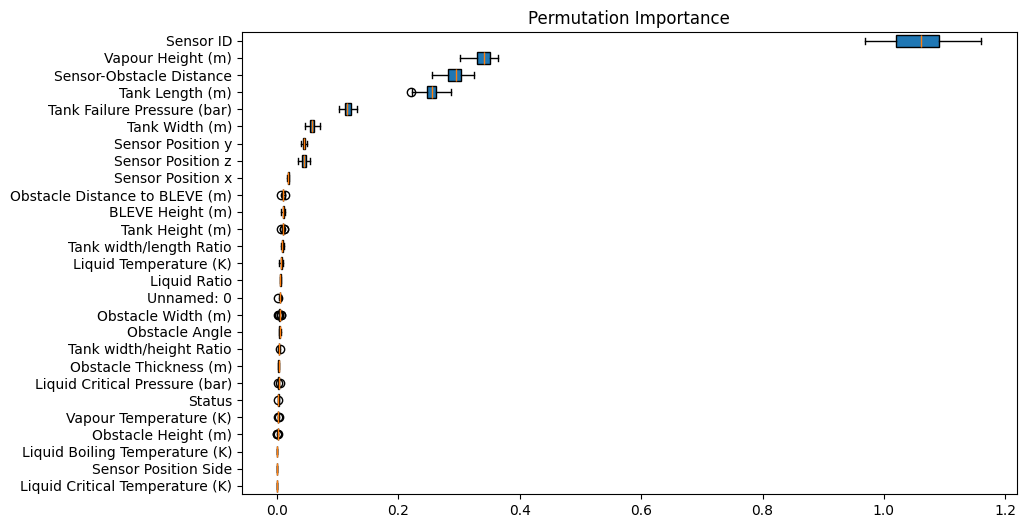

In [18]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'mean': [np.mean(r.importances[i]) for i in range(len(X.columns))],
    'dist': [r.importances[i] for i in range(len(X.columns))],
}).sort_values(by='mean')

plt.figure(figsize=(10, 6))

plt.boxplot(importance_df['dist'].values, vert=False, patch_artist=True, widths=0.7)

plt.yticks(range(1, len(importance_df) + 1), importance_df['Feature'])
plt.title('Permutation Importance')

plt.show()

In [19]:
list(importance_df['Feature'][0:])

['Liquid Critical Temperature (K)',
 'Sensor Position Side',
 'Liquid Boiling Temperature (K)',
 'Obstacle Height (m)',
 'Vapour Temperature (K)',
 'Status',
 'Liquid Critical Pressure (bar)',
 'Obstacle Thickness (m)',
 'Tank width/height Ratio',
 'Obstacle Angle',
 'Obstacle Width (m)',
 'Unnamed: 0',
 'Liquid Ratio',
 'Liquid Temperature (K)',
 'Tank width/length Ratio',
 'Tank Height (m)',
 'BLEVE Height (m)',
 'Obstacle Distance to BLEVE (m)',
 'Sensor Position x',
 'Sensor Position z',
 'Sensor Position y',
 'Tank Width (m)',
 'Tank Failure Pressure (bar)',
 'Tank Length (m)',
 'Sensor-Obstacle Distance',
 'Vapour Height (m)',
 'Sensor ID']

In [20]:
# Remove bottom 3 features
def permutation_filter(df, remove_features):
  cols_ordered = list(importance_df['Feature'])
  cols_ordered.remove('Unnamed: 0')
  cols = list(cols_ordered[remove_features:])
  return df[cols]

alternatively, I consider using PCA for 17 components

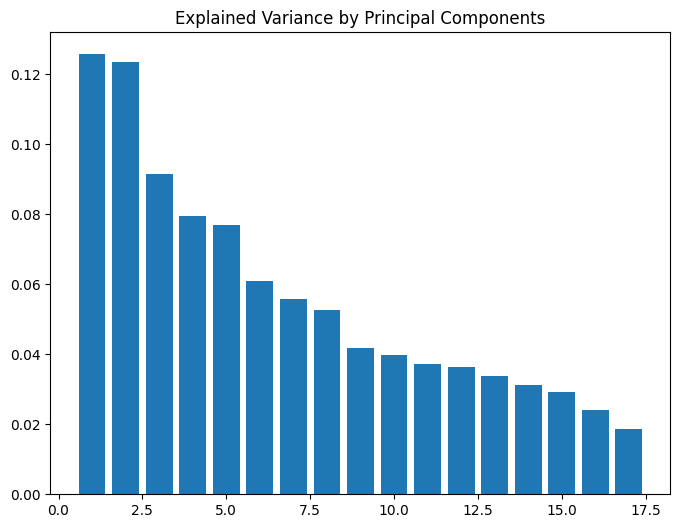

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X, y = df.drop('Target Pressure (bar)', axis=1), df['Target Pressure (bar)']
scaler = StandardScaler()

pca = PCA(n_components=17)
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.title('Explained Variance by Principal Components')
plt.show()

## Model Developement

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

df = df.drop('Unnamed: 0', axis=1, errors='ignore')
X, y =  df.drop('Target Pressure (bar)', axis=1), df['Target Pressure (bar)']

# dataset based on permutation importance selection
X_pfi = permutation_filter(X, remove_features=3)

# dataset based on PCA features
pca = PCA(n_components=17)
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)

# CV evulations for R2 and MAPE
def evaluate_cv(model, X, y, cv=4):
  r2_scores = cross_validate(model, X, y, cv=cv, scoring='r2')['test_score']
  mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
  mape_scores = cross_validate(model, X, y, cv=cv, scoring=mape_scorer)['test_score']
  return {
      "R2_mean": np.mean(r2_scores),
      "R2_std": np.std(r2_scores),
      "MAPE_mean": -np.mean(mape_scores),
      "MAPE_std": np.std(mape_scores),
  }


#### Model Selection

In [ ]:
scores = []

for X, dataset in ((X_pfi, 'Permutation importance'),
                   (X_pca, 'PCA')):

  for (model, name) in ((xgb.XGBRegressor(), 'XGboost'),
                        (RandomForestRegressor(), 'RF'),
                        (SVR(), 'SVM'),
                        (LinearRegression(), 'LR')):

    pipe = Pipeline([('scaler', StandardScaler()), (name, model)])
    m = evaluate_cv(model=pipe, X=X, y=y, cv=5)
    scores.append((dataset + ' & ' + name, m))

scores

[('Permutation importance & XGboost',
  {'R2_mean': np.float64(0.8218651710720748),
   'R2_std': np.float64(0.022153665684976596),
   'MAPE_mean': np.float64(0.35017268468785145),
   'MAPE_std': np.float64(0.025381407194609983)}),
 ('Permutation importance & RF',
  {'R2_mean': np.float64(0.7694522481398686),
   'R2_std': np.float64(0.020940774910786466),
   'MAPE_mean': np.float64(0.36930893576346935),
   'MAPE_std': np.float64(0.02796858137257)}),
 ('Permutation importance & SVM',
  {'R2_mean': np.float64(0.7599575155394789),
   'R2_std': np.float64(0.028560935257736123),
   'MAPE_mean': np.float64(0.5903621563428285),
   'MAPE_std': np.float64(0.038956408734593884)}),
 ('Permutation importance & LR',
  {'R2_mean': np.float64(0.5749597556983065),
   'R2_std': np.float64(0.014685619524845966),
   'MAPE_mean': np.float64(0.9847561982729232),
   'MAPE_std': np.float64(0.04818119572608875)}),
 ('PCA & XGboost',
  {'R2_mean': np.float64(0.6549496996108524),
   'R2_std': np.float64(0.041194

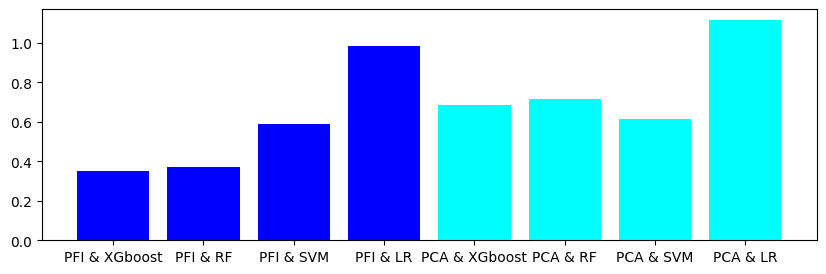

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))

for name, scores_dict in scores:
  if not name.startswith('PCA'):
    name = 'PFI'  + name[len('Perimation Importance '):]

  c = 'cyan' if name.startswith('PCA') else 'blue'
  plt.bar(name, scores_dict['MAPE_mean'], color=c)

plt.show()

* Permutation importance did better than PCA
* SVM & LR underperformed
* All methods overfit significantly

*MLP* performed best without tuning

### XGBoost

In [ ]:
!pip install optuna

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, make_scorer

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

def objective(trial):
    params = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": "gbtree",
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
    }

    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, X, y, cv=3, scoring=mape_scorer)
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best hyperparameters:", study.best_params)


In [ ]:
best_model = xgb.XGBRegressor(
    **study.best_params,
    objective="reg:squarederror",
    eval_metric="rmse",
    booster="gbtree",
    verbosity=0
)
evaluate_cv(best_model, X, y, cv=4)

### Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

def objective(trail):
  params = {
      'n_estimators': trail.suggest_int('n_estimatos', 20, 300),
      'max_depth': trail.suggest_int('max_depth', 10, 50),
      'min_samples_leaf': trail.suggest_int('min_samples_leaf', 1, 5)
  }
  model = RandomForestRegressor(**params)

  # not doing cross validation for RF, its too slow
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=0.2, random_state=0)
  model.fit(X_train, y_train)
  score =  mean_absolute_percentage_error(model.predict(X_val), y_val)
  return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)


print("Best hyperparameters:", study.best_params)

[I 2025-04-21 14:00:19,284] A new study created in memory with name: no-name-feb4bf5b-4a6a-4410-852f-28c2823ef683
[I 2025-04-21 14:00:48,406] Trial 0 finished with value: 0.29257886290088797 and parameters: {'n_estimatos': 168, 'max_depth': 13, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.29257886290088797.
[I 2025-04-21 14:01:02,531] Trial 1 finished with value: 0.27174900121036766 and parameters: {'n_estimatos': 71, 'max_depth': 18, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.27174900121036766.
[I 2025-04-21 14:01:21,081] Trial 2 finished with value: 0.2710689304410118 and parameters: {'n_estimatos': 93, 'max_depth': 47, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.2710689304410118.
[I 2025-04-21 14:01:45,351] Trial 3 finished with value: 0.27107871219275015 and parameters: {'n_estimatos': 131, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.2710689304410118.
[I 2025-04-21 14:02:39,204] Trial 4 finished with value: 0.2689569954958463

Best hyperparameters: {'n_estimatos': 146, 'max_depth': 33, 'min_samples_leaf': 1}


### Nueral Network

In [ ]:
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset

scaler = StandardScaler()
X_test_nn = np.array(test_df.drop('Unnamed: 0', axis=1))

# fit scaler to both test and training
scaler.fit(np.vstack((X, X_test_nn)))

X__labelled_nn = scaler.transform(X)
X_test_nn = torch.tensor(X_test_nn, dtype=torch.float32)

X_train, X_val, y_train, y_val = train_test_split(
    X__labelled_nn.astype(np.float32),
    np.array(y).astype(np.float32).reshape(-1, 1), test_size=0.2)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

In [ ]:
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


class NN(nn.Module):
  def __init__(self, input_size, hidden_layers):
    super(NN, self).__init__()
    layers = []
    layers.append(nn.Linear(input_size, hidden_layers[0]))
    layers.append(nn.ReLU())

    for i in range(1, len(hidden_layers)):
      layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
      layers.append(nn.ReLU())

    layers.append(nn.Linear(hidden_layers[-1], 1))
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)


class EarlyStopper:
  def __init__(self, patience=10, delta=1e-5):
    self.patience = patience
    self.delta = delta
    self.counter = 0
    self.best_score = None
    self.early_stop = False

  def check(self, model, val_loader):
    current_score = evaluate(model, val_loader)
    if self.best_score is None or current_score < self.best_score - self.delta:
      self.best_score = current_score
      self.counter = 0
    else:
      self.counter += 1

    if self.counter >= self.patience:
      self.early_stop = True

    return self.early_stop, current_score


def evaluate(model, data_loader):
  model.eval()
  all_preds, all_targets = [], []
  with torch.no_grad():
    for xb, yb in data_loader:
      preds = model(xb)
      all_preds.append(preds.numpy())
      all_targets.append(yb.numpy())

  all_preds = np.vstack(all_preds)
  all_targets = np.vstack(all_targets)
  return mean_absolute_percentage_error(all_targets, all_preds)


def train(model, train_loader, val_loader,
          epochs, lr, early_stopper=None):

  mape_scores = []
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
      optimizer.zero_grad()
      preds = model(xb)
      loss = criterion(preds, yb)
      loss.backward()
      optimizer.step()

    if early_stopper:
      should_stop, epoch_mape = early_stopper.check(model, val_loader)
      mape_scores.append(epoch_mape)
      if should_stop:
        print(f"Early stopping ended training at epoch {epoch + 1}")
        break

  final_mape = evaluate(model, val_loader)
  return final_mape, mape_scores


def objective(trial):
  # hyperparameter search space
  n_layers = trial.suggest_int("n_layers", 1, 3)
  hidden_layers = [
      trial.suggest_int(f"n_units_l{i}", 16, 128)
      for i in range(n_layers)
  ]
  lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
  model = NN(input_size=26, hidden_layers=hidden_layers)

  mape, each_mape = train(
      model,
      train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
      val_loader=DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
      epochs=15, # limited epochs for optimization
      lr=lr
  )
  return mape

# Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

print("Best trial:")
print(study.best_trial)

In [ ]:
study.best_params

{'n_layers': 3,
 'n_units_l0': 125,
 'n_units_l1': 82,
 'n_units_l2': 69,
 'lr': 0.0034579365725773397,
 'batch_size': 128}

## Final Evaluation

Early stopping ended training at epoch 231
validation MAPE:  0.1506958305835724


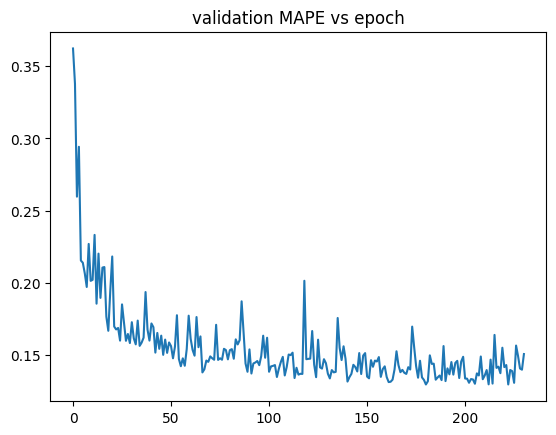

In [ ]:
# re-setup the best performing model and train untill overfitting

batch_size = 128

model = NN(hidden_layers=[125, 82, 69], input_size=26)

mape, mape_scores = train(
    model,
    train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    val_loader=DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    epochs=500,
    # rely on early stopping this time
    early_stopper=EarlyStopper(patience=50, delta=1e-5),
    lr=0.0034579365725773397,
)

print('validation MAPE: ', mape)
plt.plot(mape_scores)
plt.title('validation MAPE vs epoch')
plt.show()


# TODO: 128 is becuase evlauation epochs was low. do more epochs & less evulations

In [ ]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_nn).numpy()

y_pred

array([[0.10118693],
       [0.09592579],
       [0.11938745],
       ...,
       [0.71103466],
       [0.69867533],
       [0.6625061 ]], dtype=float32)

In [ ]:
df = pd.DataFrame({
    'Target Pressure (bar)': y_pred.reshape(len(y_pred)),
    'ID': np.array(list(range(3203)))
})

In [ ]:
df

,Target Pressure (bar),ID
0,0.101187,0
1,0.095926,1
2,0.119387,2
3,0.106834,3
4,0.108432,4
...,...,...
3198,0.837287,3198
3199,0.783544,3199
3200,0.711035,3200
3201,0.698675,3201


In [ ]:
df.to_csv('y_pred.csv', index=False)